# Breast-96-Samples.R as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## rMATS-final-merged
the rmats-nf NextFlow was executed and the results released here:

## Loading dependencies

In [1]:
library(limma)
library(multtest)
library(Biobase)
library(edgeR)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bio

In [2]:
install.packages('R.utils')
library(R.utils)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.0 (2020-02-14 07:10:20 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.23.0 successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.9.2 successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings



In [3]:
# jupyter notebooks are in one subdirectory -- data directories are up and over in another - but verify.
getwd()

[1] "/mnt/shared/gcp-user/session_data/sbas/jupyter"

In [4]:
#DS analysis

#inc.iso.counts.mem<-read.csv('/Users/karleg/Downloads/rmats_final.se.jc.ijc.txt',header=TRUE)
inc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz") 

#skip.iso.counts.mem<-read.csv('/Users/karleg/Downloads/rmats_final.se.jc.sjc.txt',header=TRUE)
skip.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz") 

meta.data<-read.csv('../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt',header=TRUE)
head(inc.iso.counts.mem)
head(skip.iso.counts.mem)
head(meta.data)

ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,26,247,103,620,494,145,145,139,697,⋯,151,32,62,48,963,25,196,76,72,61
3,1,0,1,0,0,0,1,1,2,⋯,2,1,0,1,3,0,1,0,0,0
4,0,1,1,2,0,0,1,0,2,⋯,0,0,0,0,1,0,0,0,0,0
5,3,0,2,3,6,1,1,1,5,⋯,3,2,0,1,6,0,2,0,0,0
6,2,1,2,5,6,1,1,0,5,⋯,1,1,0,0,4,0,1,0,0,0


ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,0,1,3,6,1,0,0,3,⋯,1,1,0,0,3,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,2,0,1,0,0,0
5,0,5,3,8,4,0,3,0,3,⋯,9,3,1,2,3,0,1,0,1,0
6,11,119,36,284,207,60,63,43,295,⋯,52,13,14,9,338,8,63,25,20,18


,Run,analyte_type,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type..run.,product_part_number..exp.,product_part_number..run.,sample_barcode..exp.,sample_barcode..run.,is_technical_control,target_set..exp.,primary_disease..exp.,secondary_accessions..run.,Alignment_Provider..run.
,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<lgl>,<fct>,<fct>,<lgl>
1,SRR2911715,RNA,RNA-Seq,150,3852895500,PRJNA244100,SAMN04216864,Cloud Testing,HG00103,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
2,SRR2911716,RNA,RNA-Seq,150,4885577400,PRJNA244100,SAMN04216866,Cloud Testing,HG00154,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
3,SRR2911718,RNA,RNA-Seq,150,2690545500,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
4,SRR2911719,RNA,RNA-Seq,150,2699599350,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
5,SRR2911720,RNA,RNA-Seq,152,4300467752,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
6,SRR2911717,RNA,RNA-Seq,150,2666546700,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA


Keep only the runs that are in the ijc count list (assuming ijc and sjc are the same).  As well, name the rows with the junction id column and then make the matrix just about the counts.

In [5]:
#dimensions before we make the changes.
dim(inc.iso.counts.mem)
dim(skip.iso.counts.mem)
dim(meta.data)

#logic to keep only those runs (rows) that are in the matrix of ijc counts (columns)
keep.meta.data <- meta.data$Run %in% colnames(inc.iso.counts.mem)
table(keep.meta.data)
reduced.meta.data <- meta.data[keep.meta.data==TRUE,]

# there is one more column that has the junction ID, preserve that as the row number
rownames(inc.iso.counts.mem)<-inc.iso.counts.mem$ID
rownames(skip.iso.counts.mem)<-skip.iso.counts.mem$ID

#remove the id and now we should have parity between columns (which are the runs) for ijc, sjc with rows of the metadata (which are also runs)
inc.iso.counts.mem  <-inc.iso.counts.mem[,-1]
skip.iso.counts.mem <-skip.iso.counts.mem[,-1]
dim(inc.iso.counts.mem)
dim(skip.iso.counts.mem)
dim(reduced.meta.data)

[1] 42611  8674

[1] 42611  8674

[1] 9784   79

keep.meta.data
FALSE  TRUE 
 1111  8673 

[1] 42611  8673

[1] 42611  8673

[1] 8673   79

Cool -- now we need to ensure the ordering of the metadata (rownames) is the same as the colnames, ijc and sjc.  The metadata was read in with StringsAsFactors == TRUE, we wish rearrange the order of the columns for our ijc, sjc count data to match that of the Run column of the metadata, our column names in the count data hold the Run names, we need to ensure we compare as.character (colnames can not be factors).

Using library tibble,  which we start by converting to a tibble data frame (tbl_df). Tibble is a modern rethinking of data frame providing a nicer printing method. This is useful when working with large data sets.   Using tibble, we can rearrange the columns as the column name.   Method to use is converting the ijc, sjc count data.frame to a tibble data frame.

In [6]:
library(tibble)

In [7]:
meta.data.colnames   <- as.character(reduced.meta.data$Run)
inc.iso.counts.mem2  <- as_tibble(inc.iso.counts.mem)
inc.iso.counts.mem2  <- inc.iso.counts.mem2[,c(meta.data.colnames)]
skip.iso.counts.mem2 <- inc.iso.counts.mem2[,c(meta.data.colnames)]
dim(skip.iso.counts.mem2)
dim(inc.iso.counts.mem2)

[1] 42611  8673

[1] 42611  8673

Remove samples that match '11IL0' from the ijc, sjc and metadata files

In [8]:
keep.meta.data <- (!grepl('11ILO',reduced.meta.data$Sample.Name) & (reduced.meta.data$body_site %in% 'Breast - Mammary Tissue'))
table(keep.meta.data)
inc.iso.counts.mem2  <-inc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
skip.iso.counts.mem2 <-skip.iso.counts.mem2[                    ,keep.meta.data==TRUE]
reduced.meta.data    <-reduced.meta.data   [keep.meta.data==TRUE,                    ]
dim(inc.iso.counts.mem2)
dim(skip.iso.counts.mem2)

keep.meta.data
FALSE  TRUE 
 8482   191 

[1] 42611   191

[1] 42611   191

## Modeling 



In [9]:
groups=c(paste0(reduced.meta.data$sex,'-skip'),paste0(reduced.meta.data$sex,'-inc'))
table(groups)

groups
 female-inc female-skip    male-inc   male-skip 
         81          81         110         110 

separate the matrices counts into male and female

In [10]:
inc.counts.male   <-inc.iso.counts.mem2 [,reduced.meta.data$sex=='male']

inc.counts.female <-inc.iso.counts.mem2 [,reduced.meta.data$sex=='female']

skip.counts.male  <-skip.iso.counts.mem2[,reduced.meta.data$sex=='male']

skip.counts.female<-skip.iso.counts.mem2[,reduced.meta.data$sex=='female']


make the matrix, combining now the male and female counts - achieving a rearrangement count columns included counts male, female, followed by skiped counts male female

In [11]:
inc.counts.mat<-cbind(inc.counts.male,inc.counts.female)

rownames(inc.counts.mat)<-rownames(inc.iso.counts.mem)

skip.counts.mat<-cbind(skip.counts.male,skip.counts.female)

rownames(skip.counts.mat)<-rownames(skip.iso.counts.mem)

counts.mat<-cbind(inc.counts.male,inc.counts.female,skip.counts.male,skip.counts.female)

rownames(counts.mat)<-rownames(inc.iso.counts.mem)

## isoform
Create an isoform, this will be used in the modeling.  The sum is equal to the total number of samples.   For each sample, they will be represented in each of the forms, so that the modeling could occur, it does make the assumption that there are at least 2 isoforms.   One that has representation as an isoform with includes reads on a specific junction, and one that is an isoform that excludes that particular junction.   This is an over simplification of what is an isoform.   But a useful technique for modeling for differential expression.

In [12]:
isoform<-c(rep(1,ncol(inc.counts.male)+ncol(inc.counts.female)),rep(0,ncol(skip.counts.male)+ncol(skip.counts.female)))

## sex
Encode then in the matrix the sex values.   This will also be used for making the differential analysis model.  

In [13]:
sex<-c(rep(1,ncol(inc.counts.male)),rep(0,ncol(inc.counts.female)),rep(1,ncol(skip.counts.male)),rep(0,ncol(skip.counts.female)))

## block - accounting for duplicate correlation

The counts ijc and sjc are from the same sample and are two different measure that are tightly correlated.   We want to account for that.  In order to do this, we create a counts matrix, that keeps the inclusion junction counts (male and then female) separated by the skipped junction counts (male and then female). We calculate the normalization factors by just using one of the counts, so that we don't duplicate it -- this is done by first making the matrix wide -- so that the library count information is done just one per row.   And then repeating these normalization factors in such a way to allow them to be accounted for with the duplicateCorrelation function, which is made to do so when block is defined, which we have done so, matching exactly the design as stated here.  We have two counts closely related within one sample.

In [45]:
#block=rep(c(1:ncol(inc.counts.male),(1+ncol(inc.counts.male)):(ncol(inc.counts.female)+ncol(inc.counts.male))),2)
block<-c(rep(1,c(ncol(inc.counts.male)+ncol(inc.counts.female))), rep(2, c(ncol(skip.counts.male)+ncol(skip.counts.female))))

In [46]:
block

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[223] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[260] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[297] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[334] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[371] 2 2 2 2 2 2 2 2 2 2 2 2

# removing zero rows 
Voom adds 0.05 so that the typical log2 error does not occur -- we can safely cut off values < 1.  Lets plot just to see.
The ideal here is to keep only those rows which have non-zero values


In [71]:
rowDistribution <- rowSums(counts.mat)
index <- order(rowDistribution, decreasing=FALSE)
y <- rowDistribution[index]
y.gt.1 <- y[y > 1]
y.gt.5 <- y[y > 5]
sum(y<=1)
sum(y<=5)
max(y.gt.1)
min(y.gt.1)
max(y.gt.5)
min(y.gt.5)
median(y)
median(y.gt.1)
median(y.gt.5)
log2y.gt.1 <- log2(y.gt.1)
log2y.gt.5 <- log2(y.gt.5)

[1] 2056

[1] 3402

[1] 5097456

[1] 2

[1] 5097456

[1] 6

[1] 1338

[1] 1730

[1] 2054

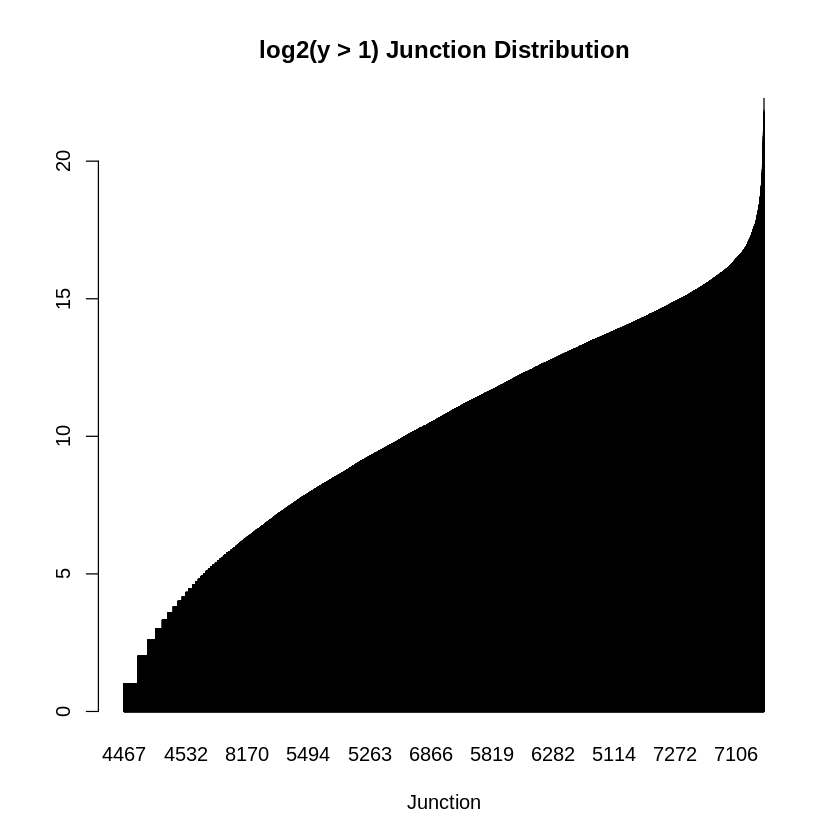

In [73]:
# Simple Bar Plot
barplot(log2y.gt.1, main="log2(y > 1) Junction Distribution",
   xlab="Junction")


In [74]:
pdf ("../pdf/log2.y.gt.1.rowcnts.pdf")
barplot(log2y.gt.1, main="log2(y > 1) Junction Distribution",
   xlab="Junction")
dev.off()

png 
  2

# Eliminate zero rows

As shown above -- there are over 2000 zero rows.  These are junctions without counts in either ijc or sjc.  We eliminate them.

In [50]:
# we will plot what we have 
keep.rows <- y > 0
table(keep.rows)

dim(counts.mat)

isoform   <-isoform   
sex       <-sex       
block     <-block     
counts.mat<-counts.mat[keep.rows==TRUE,]

dim(counts.mat)
table(block)
table(isoform)
table(sex)

keep.rows
FALSE  TRUE 
 2138 38210 

[1] 40348   382

[1] 38210   382

block
  1   2 
191 191 

isoform
  0   1 
191 191 

sex
  0   1 
162 220 

finally we are able to perform our analysis.

In [51]:
is.matrix(counts.mat)
counts.mat.dm <- data.matrix(counts.mat)
is.matrix(counts.mat.dm)
counts.mat <- counts.mat.dm

[1] TRUE

[1] TRUE

make an EDGR DGEList for our differential analysis

In [52]:
y <- edgeR::DGEList(counts=counts.mat,
                    group =block)


Repeated column names found in count matrix


## accounting for duplicate correlation

The counts ijc and sjc are from the same sample and are two different measure that are tightly correlated.   We want to account for that.  In order to do this, we create a counts matrix, that keeps the inclusion junction counts (male and then female) separated by the skipped junction counts (male and then female). We calculate the normalization factors by just using one of the counts, so that we don't duplicate it -- this is done by first making the matrix wide -- so that the library count information is done just one per row.   And then repeating these normalization factors in such a way to allow them to be accounted for with the duplicateCorrelation function, which is made to do so when block is defined, which we have done so, matching exactly the design as stated here.  We have two counts closely related within one sample.

In [53]:
counts.isoform.mat =  cbind(counts.mat[,isoform==1] + counts.mat[,isoform==0])
y.isoform          <- DGEList(counts=counts.isoform.mat)
y.isoform          <- calcNormFactors(y.isoform)
y                  <- DGEList(counts=counts.mat)
y                  <- calcNormFactors(y)

dim   (y.isoform$counts)
length(y.isoform$samples$norm.factors)
dim   (y$counts)
length(y$samples$norm.factors)

Repeated column names found in count matrix


[1] 38210   191

[1] 191

[1] 38210   382

[1] 382

In [54]:
y$samples$norm.factors=rep(y.isoform$samples$norm.factors,2)

Here we create the design matrix for our linear model, we are interested in seeing separately the impact of sex and isoform as well as their interaction factor.

In [55]:
design <- model.matrix(~sex+isoform+sex*isoform)

In [56]:
table(design[,'sex'])
table(design[,'isoform'])
table(design[,'sex:isoform'])


  0   1 
162 220 


  0   1 
191 191 


  0   1 
272 110 

## voom
mean variance plot of the raw counts and the DGEList should be the same

### voom raw counts

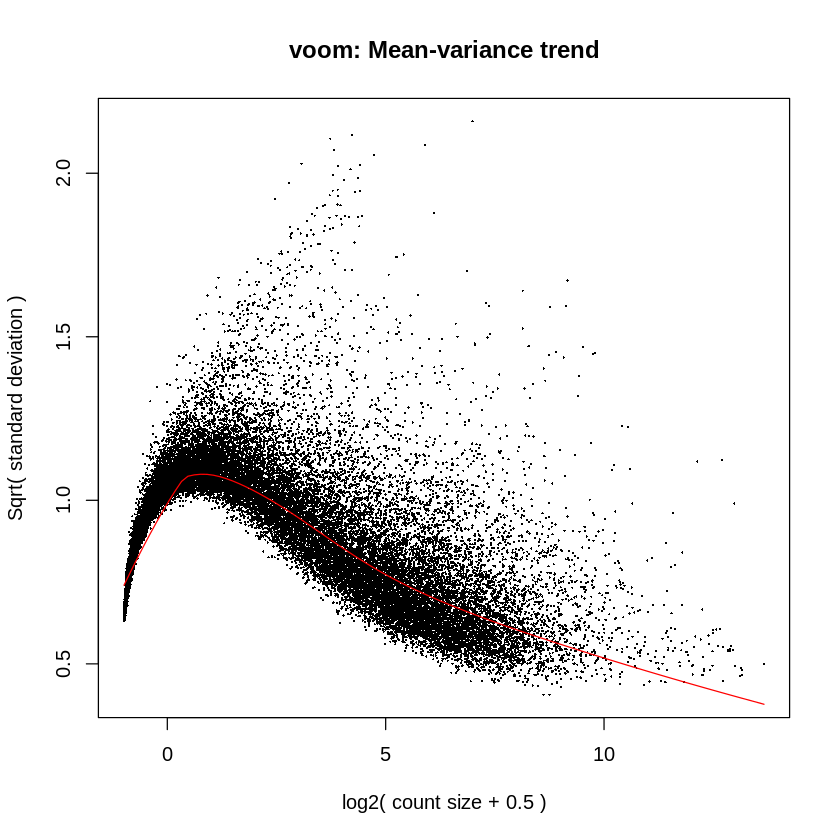

In [60]:
voom.raw.counts.mat <- voom(counts.mat,plot=TRUE, save.plot=TRUE)

### voom DGEList

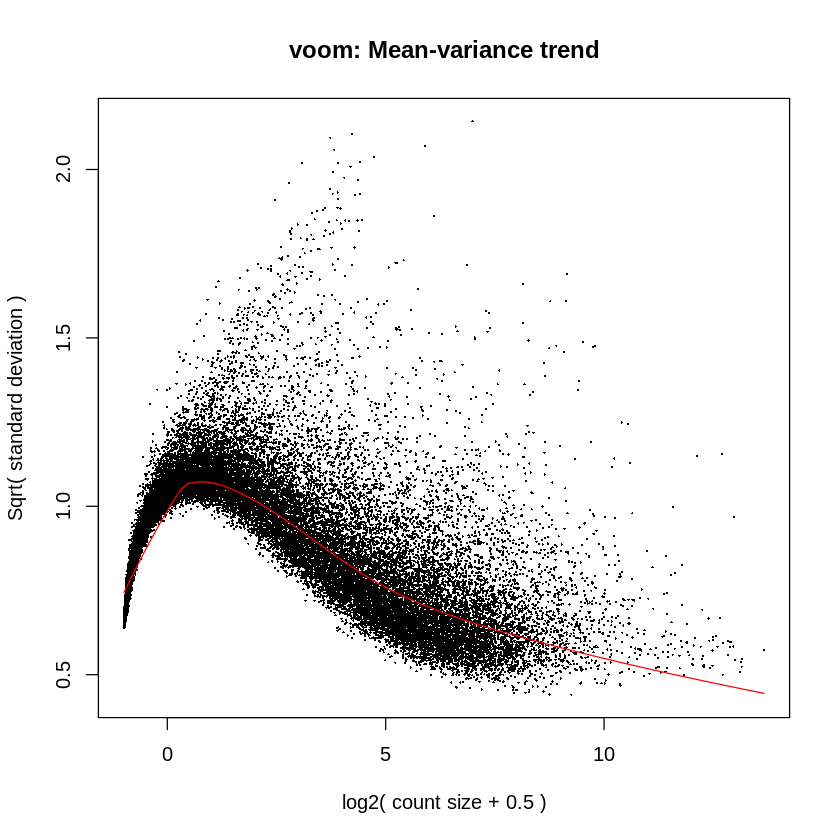

In [61]:
voom.y.DGEList <- voom(y, plot=TRUE, save.plot=TRUE)

In [62]:
head (voom.y.DGEList)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
1,1,1656165.3,0.9815651
2,1,2242038.0,0.9962470
3,1,2096604.0,1.0609818
4,1,1669714.4,1.0644351
5,1,2376675.7,1.0328321
6,1,2052775.3,1.0674958
7,1,2846794.8,1.1203562
8,1,2293998.1,1.0159789
9,1,1336702.7,0.9478145


In [63]:
head(voom.raw.counts.mat)

An object of class "EList"
$E
     SRR1090674 SRR1090791 SRR1365534 SRR1365622 SRR1429181 SRR1430615
4402   5.712914   5.087152   5.778896   5.220850   6.002231   4.595813
4403   5.278731   5.901226   6.396723   5.834301   6.168347   6.039648
4404   4.435133   4.096551   4.587200   4.617272   4.240604   4.626510
4405   3.671573   3.662654   4.556504   3.208467   3.525580   4.033934
4406   4.395055   4.544010   5.156896   4.022911   4.207051   4.876833
4407   4.753103   5.329610   5.965712   5.607874   5.611441   5.422976
     SRR1352457 SRR1357166 SRR1081023 SRR1084674 SRR1086538 SRR811285 SRR812198
4402   4.709901   5.874854   5.073852   6.572097   5.876863  5.348439  5.656895
4403   5.736767   6.096469   5.987813   6.090011   5.876863  6.156693  5.948752
4404   4.549436   4.880288   3.930262   4.741557   4.439054  4.689144  4.395154
4405   3.327044   4.300739   3.548391   3.696233   3.786977  4.048394  4.005742
4406   4.064009   5.024678   4.118707   4.164012   4.807442  4.943863  4.844679
4407   5.276670   5.432336   5.374362   5.559497   5.477873  5.790006  5.521331
     SRR820571 SRR657528 SRR1341539 SRR1342873 SRR1339236 SRR1339431 SRR615910
4402  5.080604  6.615213   5.555307   5.831628   5.862801   4.325744  5.256052
4403  5.197013  5.970544   5.745410   6.335741   6.180093   5.770156  6.081148
4404  3.740375  4.344359   4.875880   5.050097   4.544725   3.694389  4.607217
4405  3.043767  3.521237   3.493023   3.723447   4.097266   3.066357  4.048727
4406  3.858211  4.678778   3.842966   4.202100   4.725298   4.497697  4.867280
4407  4.953970  5.247062   5.427928   5.842558   5.610527   5.119995  5.524755
     SRR658105 SRR659223 SRR662306 SRR662378 SRR662811 SRR1368050 SRR1369088
4402  5.679092  5.589426  6.154886  5.484124  5.636372   5.906064   5.492687
4403  5.110808  6.258821  6.218486  5.935108  5.975730   5.931712   5.738098
4404  4.776389  4.193777  4.671895  4.330649  4.877993   4.763375   4.912494
4405  4.340290  4.248744  3.949997  3.359796  3.180920   3.886523   2.898139
4406  4.896684  5.069519  4.863120  4.497299  4.326351   4.950654   3.746136
4407  4.340290  5.396020  5.743907  5.374151  5.587737   5.418047   5.331098
     SRR1369584 SRR1370308 SRR1378284 SRR1068977 SRR1068999 SRR1071084
4402   4.920511   5.114015   4.900629   5.563506   5.256779   5.641945
4403   5.086761   5.816629   5.881000   6.115148   5.753083   5.961635
4404   4.545300   4.726992   4.255960   4.446930   4.322155   4.056983
4405   3.615009   3.833907   3.532478   3.403428   3.303776   3.760001
4406   4.296479   4.867854   4.373000   4.530186   4.247193   4.653086
4407   4.781906   5.356473   5.637594   5.737086   5.157925   5.230631
     SRR1071905 SRR1075484 SRR1076219 SRR1076441 SRR1077139 SRR1437073
4402   5.445373   6.294009   5.287259   4.937265   5.713222   5.409061
4403   5.476070   6.003038   5.786437   5.419960   6.005532   6.055700
4404   4.035497   4.133932   4.836866   3.629598   4.316075   4.858508
4405   2.076139   3.648505   3.584803   3.190714   3.894248   3.901577
4406   3.860410   4.449959   4.673808   4.073900   4.395146   4.532932
4407   4.836951   5.058381   5.116326   4.687545   5.085191   5.791394
     SRR1420936 SRR1464702 SRR1473124 SRR1481128 SRR1488586 SRR1469681
4402   4.787982   5.574225   5.853095   4.864417   5.455477   5.063035
4403   5.443828   5.225421   6.343082   5.153923   5.645195   5.769904
4404   4.144774   3.909645   4.412523   4.162641   4.524009   4.632400
4405   2.713435   3.484340   4.071486   3.213866   3.596521   3.278763
4406   4.044080   4.504804   5.008292   4.529068   4.263946   3.853000
4407   5.035363   4.504804   5.701536   4.798828   5.123768   5.423535
     SRR1467522 SRR1455861 SRR1469279 SRR1485398 SRR1415257 SRR1472907
4402   4.946473   5.704430   5.810120   4.741634   5.627316   4.950032
4403   5.336655   6.637316   6.460000   5.572397   6.334380   5.304214
4404   4.091290   5.005810   4.964535   3.937030   4.865476   3.659130
4405   3.844375   4.204356   3.886533   3.3229

# duplicateCorrelation
Using the block design, and noting that likely, on average, there are at least 2 junctions for a skipped exon event, if we analyze the other events, such as mutually exclusive exons, the number of junctions will be different, we can model the multiple features.  There may be an argument for a different way of proceeding with this modeling.  For example, one could model in the design model itself this feature or argue that the feature is accounted for in the isoform definition.   Warnings occur in the underlying modeling program used here, a gamma generalized linear model by Fisher Scoring with Identity link.  statmod::glmgam.fit.  This function implements a modified Fisher scoring algorithm for generalized linear models, similar to the Levenberg-Marquardt algorithm for nonlinear least squares. The Levenberg-Marquardt modification checks for a reduction in the deviance at each step, and avoids the possibility of divergence. The result is a very secure algorithm that converges for almost all datasets.

In [66]:
dup.corr = duplicateCorrelation(voom.y.DGEList,ndups=2,block=block)

Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable

## voom 

We have now obtained the model for the correlation between the two features of ijc and sjc to be used in the model.
we will use the just now calculated correlation event.   Our counts data will now be converted to log2 counts.

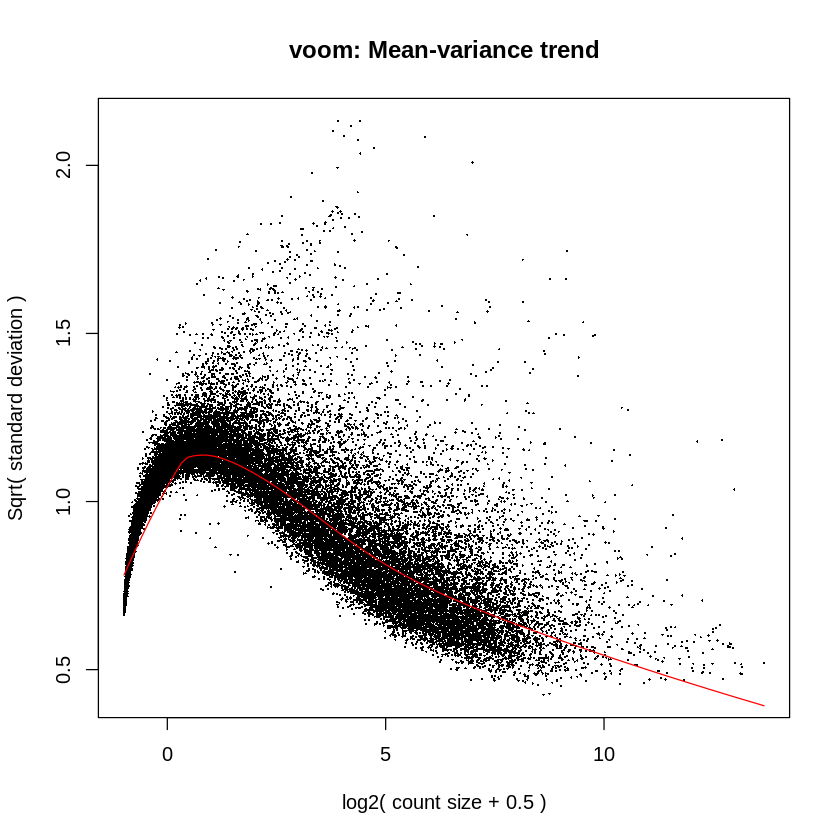

In [83]:
v.with.block <- voom(counts.mat, design=design, block=block, correlation = dup.corr$consensus.correlation, plot=TRUE, save.plot=TRUE)

Let us see the results without the blocks in the design.

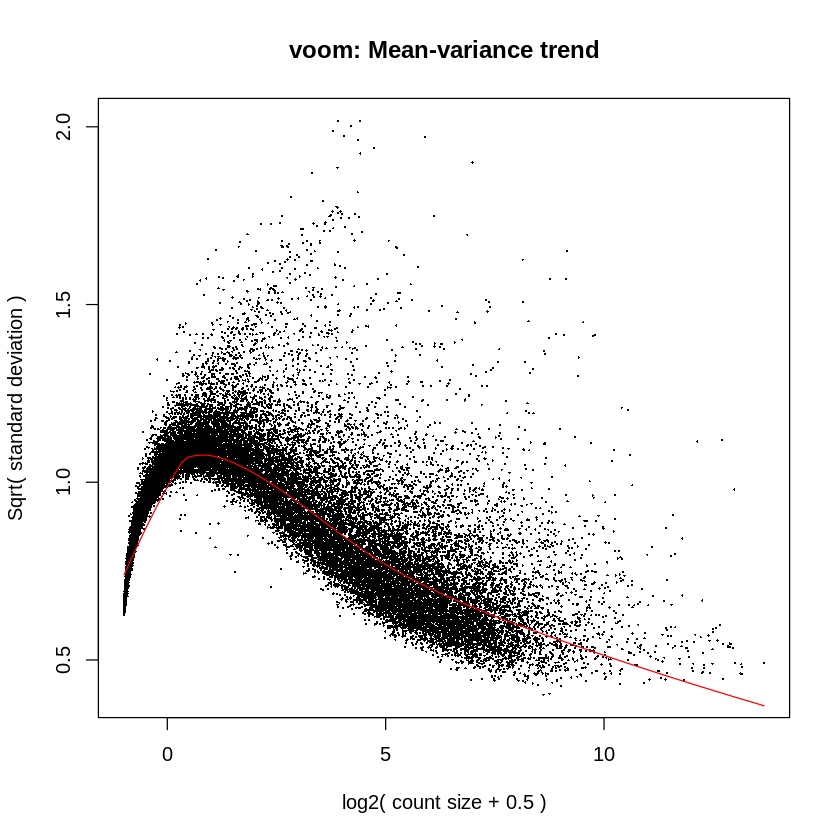

In [102]:
v <- voom(counts.mat, design=design, plot=TRUE, save.plot=TRUE)

## Bayes fit


In [106]:
fit <- lmFit(v$E, design)
fit <- eBayes(fit)
sex.res         = topTable(fit, coef='sex',         number=nrow(counts.mat))
sex.isoform.res = topTable(fit, coef='sex:isoform', number=nrow(counts.mat))
isoform.res     = topTable(fit, coef='isoform',     number=nrow(counts.mat))

In [115]:
fit.corr <- lmFit(v$E, design=design, block=block, correlation=dup.corr$consensus.correlation)
fit.corr <- eBayes(fit.corr)
sex.res.corr         = topTable(fit.corr, coef='sex',         number=nrow(counts.mat))
sex.isoform.res.corr = topTable(fit.corr, coef='sex:isoform', number=nrow(counts.mat))
isoform.res.corr     = topTable(fit.corr, coef='isoform',     number=nrow(counts.mat))

In [116]:
head(sex.res)
head(sex.res.corr)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34357,7.437616,2.770645,80.89214,4.291939e-242,1.639950e-237,526.2271
19070,5.713092,1.424739,78.02650,1.835881e-236,3.507451e-232,514.6005
19076,6.158461,1.657191,73.78469,8.774638e-228,1.117596e-223,496.5229
5965,6.440075,1.882556,71.60959,3.663068e-223,3.499146e-219,486.8259
6300,6.469556,1.869497,70.69466,3.497382e-221,2.672699e-217,482.6560
5962,6.546983,1.903620,70.65496,4.267218e-221,2.717507e-217,482.4738


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34357,7.437616,2.770645,80.89214,4.291939e-242,1.639950e-237,526.2271
19070,5.713092,1.424739,78.02650,1.835881e-236,3.507451e-232,514.6005
19076,6.158461,1.657191,73.78469,8.774638e-228,1.117596e-223,496.5229
5965,6.440075,1.882556,71.60959,3.663068e-223,3.499146e-219,486.8259
6300,6.469556,1.869497,70.69466,3.497382e-221,2.672699e-217,482.6560
5962,6.546983,1.903620,70.65496,4.267218e-221,2.717507e-217,482.4738


In [117]:
head(isoform.res)
head(isoform.res.corr)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4402,-5.276438e-17,5.348000,-7.026969e-16,1,1,-4.97973
4403,2.571268e-17,5.864998,3.957771e-16,1,1,-4.97973
4404,2.393158e-17,4.323135,3.694313e-16,1,1,-4.97973
4405,-5.717182e-17,3.737960,-7.387438e-16,1,1,-4.97973
4406,-5.852748e-17,4.470077,-7.635076e-16,1,1,-4.97973
4407,8.076722e-18,5.316748,1.312400e-16,1,1,-4.97973


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4402,1.702928e-15,5.348000,4.920953e-15,1,1,-4.621665
4403,-1.556115e-15,5.864998,-5.197216e-15,1,1,-4.621665
4404,-1.313584e-16,4.323135,-4.399929e-16,1,1,-4.621665
4405,7.212905e-17,3.737960,2.022310e-16,1,1,-4.621665
4406,-1.239851e-15,4.470077,-3.509529e-15,1,1,-4.621665
4407,-5.424950e-15,5.316748,-1.912725e-14,1,1,-4.621665


In [118]:
head(sex.isoform.res)
head(sex.isoform.res.corr)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4402,-2.988288e-16,5.348000,-3.020156e-15,1,1,-4.85062
4403,-2.924079e-16,5.864998,-3.415641e-15,1,1,-4.85062
4404,-4.774669e-16,4.323135,-5.593520e-15,1,1,-4.85062
4405,-1.082005e-16,3.737960,-1.061013e-15,1,1,-4.85062
4406,-2.241886e-16,4.470077,-2.219457e-15,1,1,-4.85062
4407,-7.900008e-17,5.316748,-9.741778e-16,1,1,-4.85062


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4402,3.400767e-16,5.348000,3.437034e-15,1,1,-4.85062
4403,4.640098e-16,5.864998,5.420137e-15,1,1,-4.85062
4404,2.751254e-16,4.323135,3.223091e-15,1,1,-4.85062
4405,5.895732e-16,3.737960,5.781350e-15,1,1,-4.85062
4406,8.669265e-16,4.470077,8.582533e-15,1,1,-4.85062
4407,4.179342e-15,5.316748,5.153694e-14,1,1,-4.85062


In [125]:

filename      = paste(paste('../data/Breast - Mammary Tissue',collapse='.'),'.sex.se.txt',sep='')
genesFilename = paste(paste('../data/Breast - Mammary Tissue',collapse='.'),'.sex.all_genes.txt',sep='')

sex.res.pVal.0.05.logFC.gt.1.5 <- sex.res$adj.P.Val <= 0.05 & abs(sex.res$logFC) > 1.5
table(sex.res.pVal.0.05.logFC.gt.1.5)

sex.res.refined <- sex.res[sex.res.pVal.0.05.logFC.gt.1.5==TRUE,]

write.table(sex.res.refined,          file=filename,      row.names = T, col.names = T, quote = F)
write.table(rownames(sex.res.refined),file=genesFilename, row.names = T, col.names = T, quote = F)


sex.res.pVal.0.05.logFC.gt.1.5
FALSE  TRUE 
37789   421 

## Ontologizer


In [127]:
meta.data       <-read.table('../data/fromGTF.SE.txt',sep='\t',header=TRUE)
all.genes       <-read.table('../data/Breast - Mammary Tissue.sex.all_genes.txt')
de.tab          <-read.table('../data/Breast - Mammary Tissue.sex.se.txt')

de.tab.with.meta<-merge(de.tab,meta.data,by.x='row.names',by.y='ID')


In [136]:
dim(de.tab.with.meta)
head(de.tab.with.meta)

[1] 421  17

,Row.names,logFC,AveExpr,t,P.Value,adj.P.Val,B,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,10062,-1.602090,1.038699,-5.264306,2.355550e-07,6.246049e-06,6.218266,ENSG00000185664.14,PMEL,chr12,-,55961316,55961463,55958472,55958607,55965935,55966025
2,10063,-1.694949,1.729934,-5.234072,2.745030e-07,7.154679e-06,6.070937,ENSG00000185664.14,PMEL,chr12,-,55961316,55961463,55958472,55958607,55961621,55961732
3,10064,-1.624251,1.471918,-5.137351,4.457309e-07,1.099508e-05,5.604553,ENSG00000185664.14,PMEL,chr12,-,55961621,55961732,55961316,55961463,55965935,55966022
4,10067,-1.885288,1.815175,-5.934590,6.624349e-09,2.681318e-07,9.669363,ENSG00000185664.14,PMEL,chr12,-,55957922,55958084,55956948,55957671,55958472,55958607
5,10071,-2.553540,2.335060,-6.658337,9.682182e-11,6.513313e-09,13.776302,ENSG00000119411.11,BSPRY,chr9,+,113368258,113368383,113362368,113362394,113369615,113371222
6,10140,-1.585129,1.318925,-5.664566,2.908148e-08,9.893549e-07,8.237080,ENSG00000181085.15,MAPK15,chr8,+,143717693,143717792,143716348,143716443,143718046,143718076


## subset
Based upon our significant results, keep only those subsetted genes


In [138]:
subset <- meta.data$ID %in% all.genes[,1]
table(subset)
significant.genes <- meta.data$geneSymbol[subset==TRUE]
length(significant.genes)

subset
FALSE  TRUE 
42190   421 

[1] 421

## Ontologizer

Use the ontologizer to show the significance of the subsetted genes against the backdrop of all the genes within the experiment set.
rMATS stores this in the fromGTF folder in the geneSymbol category

In [142]:
setwd('/mnt/shared/gcp-user/session_data/sbas/jupyter')
getwd()

[1] "/mnt/shared/gcp-user/session_data/sbas/jupyter"

In [143]:
write.table(meta.data$geneSymbol,       '../data/universe.txt',quote = F,row.names = F,col.names = F)
write.table(de.tab.with.meta$geneSymbol,'../data/gene_set.txt',quote = F,row.names = F,col.names = F)

In [147]:
system('java -jar ../../ontologizer/Ontologizer.jar -g ../../ontologizer/go.obo -a ../../ontologizer/goa_human.gaf -s ../data/gene_set.txt -p ../data/universe.txt -c Term-For-Term -m Benjamini-Hochberg -n -o ../data')

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [148]:
notebookid   = "Breast-96-Samples"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!

Warning message in data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), :
“Stopped early on line 27. Expected 2 fields but found 5. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<ec7624ff879748d6b227e60209f45cd91f4d3c0294dd1b49a9c1b31db67be064  ./Breast - Mammary Tissue.sex.se.txt>>”

sha256sum,file
<chr>,<chr>
ebe1713963cd88e7bb2ac961e7d7209b38d2b0e8136b28fe4425ac8d04ad0b18,./rmats_final.mxe.jcec.skiplen.txt.gz
f117a76a29a921bea1c77bebafaa6a94e294a00e9da740daf8e12c7c5c4ddc3b,./.ipynb_checkpoints/anno-gene_set-Term-For-Term-Benjamini-Hochberg-checkpoint.txt
826bf6c7711ea5ba48469c1612ffb238551441fcc81fb840e971584f0d6758d7,./.ipynb_checkpoints/table-gene_set-Term-For-Term-Benjamini-Hochberg-checkpoint.txt
be53124f034b2e33e0868604b2ff8f8864af7427a39127229de888cb9b12420a,./reduced_y.rds
1d057b2b0283a0f2541219ee1c3cb83c1e2aa650d007c04c8cd3bc39493e7bd0,./rmats_final.ri.jc.skiplen.txt.gz
d802915847965a30ca0c8d6486dc4c8c5a64984c11aadeee8eb1d8484ba0b248,./rmats_final.se.jc.inc.txt.gz
28764f9f1e0f14e399d555e448b5490c7221454e7d34d220f79b537376ca017b,./fromGTF.novelEvents.SE.txt
86f3a2b104b1ffe297df668b0b0e1e4d5f61836c3ad8a574b89bf24a090ca9c0,./rmats_final.ri.jc.sjc.txt.gz
85acd073d8742ef4a680a10ed509ccf6779f9fbfa86fb3fd2c5629ddfa7094dd,./rmats_final.a5ss.jc.skiplen.txt.gz


### 2. Libraries metadata

In [150]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-06                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
multtest,multtest,2.40.0,2.40.0,/opt/conda/lib/R/library/multtest,/opt/conda/lib/R/library/multtest,TRUE,FALSE,2019-05-02,Bioconductor,NA,/opt/conda/lib/R/library
R.methodsS3,R.methodsS3,1.8.0,1.8.0,/opt/conda/lib/R/library/R.methodsS3,/opt/conda/lib/R/library/R.methodsS3,TRUE,FALSE,2020-02-14,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.oo,R.oo,1.23.0,1.23.0,/opt/conda/lib/R/library/R.oo,/opt/conda/lib/R/library/R.oo,TRUE,FALSE,2019-11-03,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.utils,R.utils,2.9.2,2.9.2,/opt/conda/lib/R/library/R.utils,/opt/conda/lib/R/library/R.utils,TRUE,FALSE,2019-12-08,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
tibble,tibble,2.1.3,2.1.3,/opt/conda/lib/R/library/tibble,/opt/conda/lib/R/library/tibble,TRUE,FALSE,2019-06-06,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
